<a href="https://colab.research.google.com/github/BeverlyHuang/mobile_price/blob/master/Mobile_Pricing.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#Applying Machine Learning to Mobile Pricing

Pricing is a very powerful tool in business. No matter you are creating a new product or starting a new business, you need to think about how to price your product smartly. Especially in a competitive market, if you are good at pricing, you can differentiate yourself from your competitors and get more market share. 

Thus,  the problem is how do we price our product. This project will use mobile phone market as an example to illustrate the machine learning method we can use for pricing.


#Ingestion

##Import Libraries

In [0]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from mlxtend.classifier import StackingClassifier

from scipy.stats import randint
from sklearn import model_selection
from sklearn.model_selection import train_test_split, GridSearchCV, RandomizedSearchCV
from yellowbrick.classifier import ConfusionMatrix
from sklearn.metrics import classification_report
%matplotlib inline

##Load Data

The dataset contains data on different mobile phone features such as battery power, internal memory, etc. and its selling price. 
The last column is our target - price. In this case, prices are in ranges. The larger the number, the higher the price of the phone.

In [76]:
mobile = pd.read_csv("https://raw.githubusercontent.com/BeverlyHuang/mobile_price/master/train.csv")
mobile.head()

,battery_power,blue,clock_speed,dual_sim,fc,four_g,int_memory,m_dep,mobile_wt,n_cores,...,px_height,px_width,ram,sc_h,sc_w,talk_time,three_g,touch_screen,wifi,price_range
0,842,0,2.2,0,1,0,7,0.6,188,2,...,20,756,2549,9,7,19,0,0,1,1
1,1021,1,0.5,1,0,1,53,0.7,136,3,...,905,1988,2631,17,3,7,1,1,0,2
2,563,1,0.5,1,2,1,41,0.9,145,5,...,1263,1716,2603,11,2,9,1,1,0,2
3,615,1,2.5,0,0,0,10,0.8,131,6,...,1216,1786,2769,16,8,11,1,0,0,2
4,1821,1,1.2,0,13,1,44,0.6,141,2,...,1208,1212,1411,8,2,15,1,1,0,1


#EDA

##Correlation Heatmap

To understand the relationship between the features of a mobile phone and its selling price, I use Seaborn Correlation Heatmap to visualize correlations between all variables. From the Heatmap, we can see that ram, battery power, internal memory and dual sim have higher correlation with selling price than any other features.


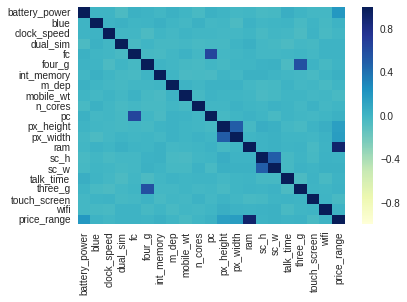

In [57]:
corr = mobile.corr()
sns.heatmap(corr, 
            xticklabels=corr.columns.values,
            yticklabels=corr.columns.values, 
            cmap='YlGnBu')

##Ram vs Price

I take out each feature and use Seaborn plots to look at their relationships with selling price.
The joint plot shows the distribution of both variables and the density of all data points. We can see that the higher the ram, the higher the price range.

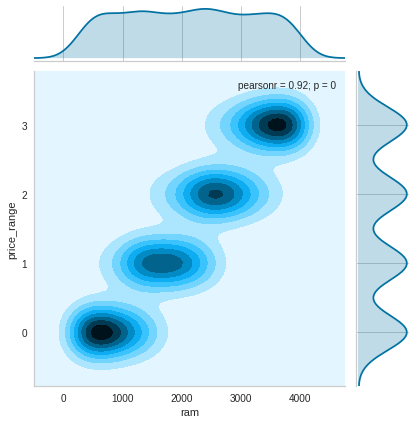

In [58]:
sns.jointplot(x="ram", y="price_range", data=mobile, kind="kde")

##Battery Power vs Price

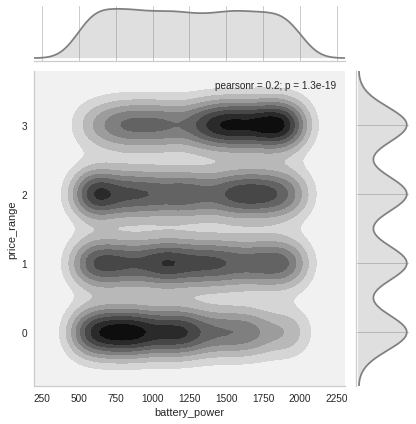

In [59]:
sns.jointplot(x="battery_power", y="price_range", data=mobile, kind="kde", color="grey")

##Memory vs Price

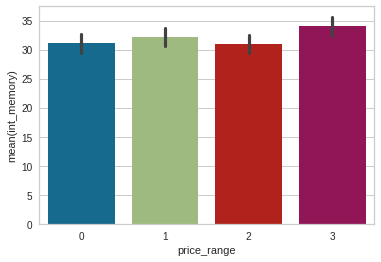

In [60]:
sns.barplot(x="price_range", y="int_memory", data=mobile)

##Dual sim vs Price

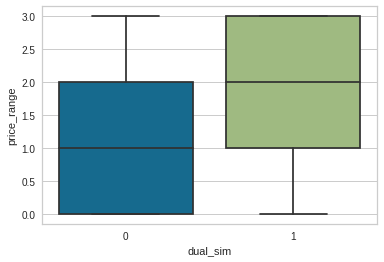

In [61]:
sns.boxplot(x="dual_sim", y="price_range", data=mobile)

#Classification Modeling

I want to build a classification model to classify price range based on product features.

###Seperate features and target

In [0]:
X=mobile.drop('price_range',axis=1)
y=mobile['price_range']

###Train/Test split

In [0]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=100, stratify=y)

##Model 1: KNN

###Find the best K to build a KNN model

What K (number of nearest neighbors) should we choose?

####Method 1: Plot testing accuracy and select the K with highest accuracy

I plot training and testing accuracy of the KNN model for K values from 1 to 30. When K = 15, the model has the highest testing accuracy.

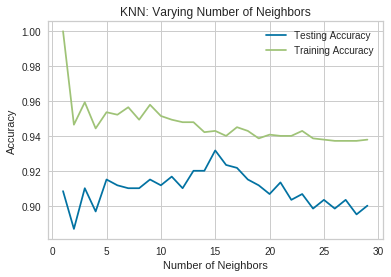

In [64]:
# set up array to store train/test accuracy
neighbors = np.arange(1,30)
train_accuracy = np.empty(len(neighbors))
test_accuracy = np.empty(len(neighbors))

# loop over different k
for i, k in enumerate(neighbors):
  knn = KNeighborsClassifier(n_neighbors = k)
  knn.fit(X_train, y_train)
  train_accuracy[i] = knn.score(X_train, y_train)
  test_accuracy[i] = knn.score(X_test, y_test)

# generate plot
plt.title("KNN: Varying Number of Neighbors")
plt.plot(neighbors, test_accuracy, label = "Testing Accuracy")
plt.plot(neighbors, train_accuracy, label = "Training Accuracy")
plt.legend()
plt.xlabel("Number of Neighbors")
plt.ylabel("Accuracy")
plt.show()

#### Method 2: Use GridSearchCV to automatically search for the best K

I use another method called Grid Search cross validation. This method will try a bunch of K values, fit all of them separately and tell me which K performs best. This method also gives me the same answer: K = 15.

In [79]:
param_grid = {'n_neighbors': np.arange(1,30)}
knn_cv = GridSearchCV(knn, param_grid, cv=7)
knn_cv.fit(X_train,y_train)
knn_cv.best_params_

{'n_neighbors': 15}

###Use the best K to predict

So I use K = 15 to build the KNN model and predict test data, and accuracy is 93%.

In [80]:
y_pred = knn_cv.predict(X_test)
knn_cv.score(X_test,y_test)

0.9316666666666666

##Model 2: Logistics Regression

### Set up hyperparameter grid

In [0]:
c_space = np.logspace(-5,8,15)
param_grid = {'C': c_space}

### GridSearch for best parameters

In [83]:
logreg = LogisticRegression()
logreg_cv = GridSearchCV(logreg, param_grid, cv=7)
logreg_cv.fit(X_train,y_train)
logreg_cv.best_params_

{'C': 163789.3706954068}

###Use the best parameters to predict

In [84]:
y_pred = logreg_cv.predict(X_test)
logreg_cv.score(X_test,y_test)

0.81

##Model 3: Decision Tree

### Set up hyperparameter grid

In [0]:
param_dist = {'max_depth': np.arange(1,30),
             'max_features': np.arange(2,9),
             'min_samples_leaf': np.arange(1,9),
             'criterion': ['gini', 'entropy']}

### GridSearch for best parameters

In [86]:
tree = DecisionTreeClassifier()
tree_cv = RandomizedSearchCV(tree, param_dist, cv=7)
tree_cv.fit(X_train, y_train)
tree_cv.best_params_

{'criterion': 'entropy',
 'max_depth': 11,
 'max_features': 6,
 'min_samples_leaf': 7}

###Use the best parameters to predict

In [87]:
y_pred = tree_cv.predict(X_test)
tree_cv.score(X_test,y_test)

0.785

##Model 4: Random Forest

### Set up hyperparameter grid

In [0]:
param_grid = {'n_estimators': [200, 500],
    'max_features': ['auto', 'sqrt', 'log2'],
    'max_depth' : np.arange(3,10),
    'min_samples_leaf': np.arange(2,8),
    'criterion' :['gini', 'entropy']}

### GridSearch for best parameters

In [89]:
rfc=RandomForestClassifier(random_state=42)
rfc_cv = RandomizedSearchCV(rfc, param_grid, cv=7)
rfc_cv.fit(X_train, y_train)
rfc_cv.best_params_

{'criterion': 'gini',
 'max_depth': 7,
 'max_features': 'auto',
 'min_samples_leaf': 2,
 'n_estimators': 200}

###Use the best parameters to predict

In [90]:
y_pred = rfc_cv.predict(X_test)
rfc_cv.score(X_test,y_test)

0.8416666666666667

##Model 5: Stacking (Combination of Multiple Models)

In [0]:
clf1 = knn_cv
clf2 = logreg_cv
clf3 = tree_cv
clf4 = rfc_cv
sclf = StackingClassifier(classifiers=[clf1, clf2, clf3],
                          use_probas=True,
                          average_probas=False,
                          meta_classifier=clf4)

In [92]:
sclf.fit(X_train,y_train) 
y_pred = sclf.predict(X_test)
sclf.score(X_test,y_test)

0.89

##Prection Using the Best Model (KNN)

###Confusion Matrix

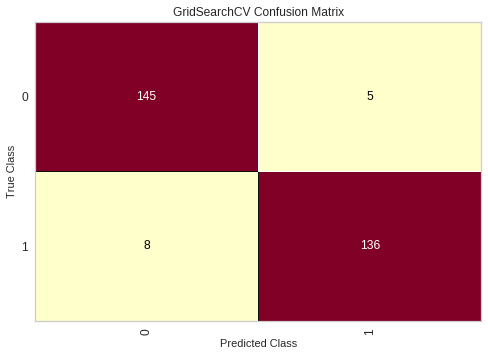

In [28]:
cm = ConfusionMatrix(knn_cv, classes=[0,1])
cm.fit(X_train, y_train)
cm.score(X_test, y_test)
cm.poof()

###Classfication Report

From the classification report, we can see that both precision and recall are very high. Thus, we are confident that this is a good model to use in pricing.

In [0]:
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.95      0.97      0.96       150
           1       0.92      0.91      0.91       150
           2       0.90      0.91      0.91       150
           3       0.96      0.94      0.95       150

   micro avg       0.93      0.93      0.93       600
   macro avg       0.93      0.93      0.93       600
weighted avg       0.93      0.93      0.93       600



##Conclusion

* In this project, I use mobile phone as an example to illustrate how to use product features and competitors’ pricing information to build a pricing model for our products. 

* Four classification models (KNN, logistics regression, decision tree, random forest) are built using the best parameters selected by GridSearch Cross Validation.
  1.   The KNN model achieves 93% accuracy.
  2.   The logistics regression model achieves 81% accuracy.
  3.   The decision tree model achieves 78.5% accuracy.
  4.   The random forest model achieves 84% accuracy.

* Stacking Classification model is also created by combining four models above, which achieves accuracy of 89%. So KNN is the best prediction model for this dataset.

* With this model, we can price mobile phones based on their features easily. Simply telling the machine what are the features of your product, it will give you a recommended price. 
* This pricing model can be implemented in other products and industries. It incorporates both value-based pricing (which considers product value) and competitive pricing (which considers competitors’ pricing). Thus, it is a good model for new product pricing.